# Introducing Neural Nets: Part 2

This notebook:

- Keras Functional API
- Subclassing API
- Saving Models
- Callbacks
- TensorBoard


### Let's Start With a Demo

http://playground.tensorflow.org

In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

## A Regression Model in Keras

- Let's review keras, start with a simple regression model this time:

In [2]:
#Get started:

#tf.keras.backend.clear_session()
#tf.random.set_seed(42)

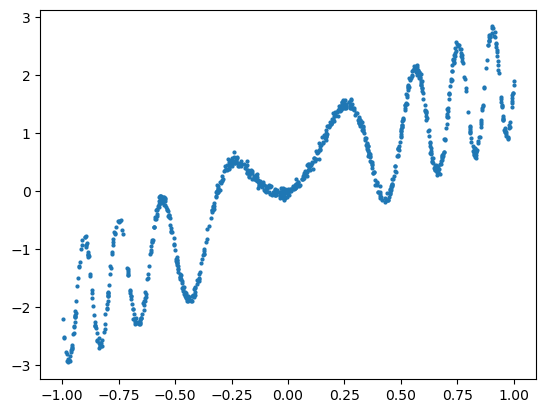

In [3]:
#Some synthetic data
N = 1000

#Random points sorted
x = np.random.uniform(-1, 1, N)
x.sort()

#Equation with complicated first part, simple linear second part:
y = np.sin((x*10)) + 2*x + np.random.normal(loc=0, scale=.05, size=N)

#Alt:
y = np.sin((x*5)**2) + 2*x + np.random.normal(loc=0, scale=.05, size=N)

#Plot our data:
plt.plot(x, y, 'o', markersize=2);

In [4]:
#Let's optionally add a few modifications of x:
add_features = True

if (add_features):
    X_np = np.c_[x, x**2, np.sin(x)]

    #And convert to DataFrame:
    X = pd.DataFrame(X_np, columns = ['x', 'x2', 'sin_x'])
    
else:
    X_np = x.reshape(-1,1)
    X = pd.DataFrame(X_np, columns = ['x'])
    
    
## Similarly, make y a Series:
y = pd.Series(y)

#If we just had x:
#X = x.reshape(-1,1)

In [5]:
## And train-test split:
from sklearn.model_selection import train_test_split

#Initial Train/Test Split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

#Let's also create a simple validation set:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.1, random_state=42)

In [6]:
#Let's sort X_test for later display purposes
####

X_test = X_test.sort_values(by = 'x')
X_test.head()

,x,x2,sin_x
0,-0.997566,0.995137,-0.840153
2,-0.991044,0.982167,-0.836598
3,-0.981863,0.964054,-0.831533
5,-0.979630,0.959674,-0.830291
6,-0.972980,0.946690,-0.826567


In [7]:
### And match y_test by index:
y_test = y_test.loc[X_test.index]
y_test.head()

0   -2.212465
2   -2.533542
3   -2.777491
5   -2.936074
6   -2.961704
dtype: float64

In [8]:
### Now define a model using the Sequential API:
##########

In [9]:
#Let's include a normalization layer this time:
#Note the shape:
normalization_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])

#Now we can declare our sequential model like so; a little different from last time
model = tf.keras.Sequential([
    normalization_layer,
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    #tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

#Get an optimizer, specify learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

#Compile the model: Specify loss
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

#Now, we call ADAPT to perform the normalization:
#Also, this is a method of the normalization layer itself:
##########
normalization_layer.adapt(X_train)

<Axes: >

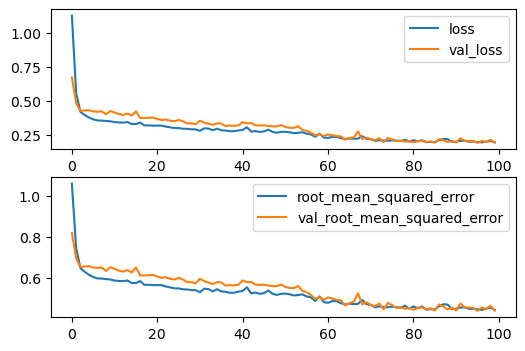

In [10]:
## Let's fit
## Run this cell a couple times

history = model.fit(X_train, y_train, epochs=100, 
                    validation_split=0.1, verbose=False)

#See how we did:
#Make DataFrame
df = pd.DataFrame(history.history)

## Plot
fig, ax1 = plt.subplots(2,1, figsize=(6,4))

df[['loss', 'val_loss']].plot(ax=ax1[0])
df[['root_mean_squared_error', 'val_root_mean_squared_error']].plot(ax=ax1[1])

In [11]:
## And predict for model1 on test set:
y_pred1 = model.predict(X_test)


13/13 [==============================] - 0s 667us/step


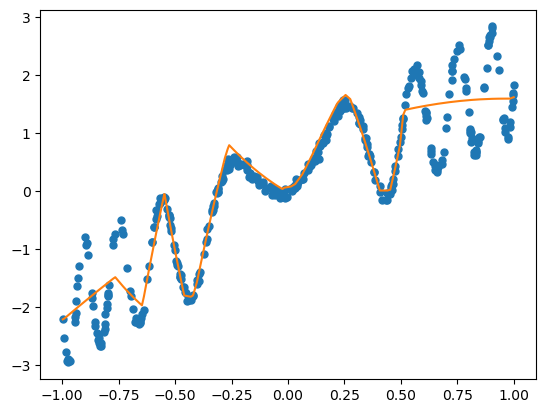

In [12]:
#Plot our data:
plt.plot(X_test.x, y_test, 'o', markersize=5);
plt.plot(X_test.x, y_pred1);

## A note on structure: Shallow and Wide or Narrow and Deep?

- A single layer, sufficiently large, could in principle capture any nonlinear transformation of the input
- More smaller stacked layers is much more efficient:
    - Lower layers learn more primitive patterns
    - Combined into higher-order patterns by upper layers
    - Example: Draw a tree: More to get stereotyped leaves, branches, roots, and put together than to make all at once

## Functional API

Let's build a *Wide and Deep*  neural network. Idea is to:

- Learn complex rules through the deep path
- Learn simple rules through the short path

<img src="wide_and_deep.png" alt="Wide and Deep Architecture" style="width:325px;"/>

<br>

Let's start by defining such a regression model using the Functional API:

In [13]:
#We'll start with a normalization layer:
normalization_layer = tf.keras.layers.Normalization()

#Deep Path
hidden_layer1 = tf.keras.layers.Dense(10, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(10, activation="relu")

#Join wide and deep paths:
concat_layer = tf.keras.layers.Concatenate()

#Final output
output_layer = tf.keras.layers.Dense(1)


#Make an input layer
input_layer = tf.keras.layers.Input(shape=X.shape[1:])

#And now get the normalization of the input layer:
normalized = normalization_layer(input_layer)

#Apply hidden_layer1 to normalized input, gives us hidden1 as output
hidden1 = hidden_layer1(normalized)

#Apply hidden_layer2 to hidden1, get hidden2 as output
hidden2 = hidden_layer2(hidden1)

#Concatenate hidden2 and normalized together
concat = concat_layer([normalized, hidden2])

#Without normalized:
#concat = concat_layer([hidden2])

#Use concat as input to the final output_layer, get output as result
output = output_layer(concat)

#Finally, put all together as the keras model with inputs and outputs as follows:
model_wd = tf.keras.Model(inputs=[input_layer], outputs=[output])

In [14]:
#Let's summarize all this:

model_wd.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 normalization_1 (Normaliza  (None, 3)                    7         ['input_1[0][0]']             
 tion)                                                                                            
                                                                                                  
 dense_3 (Dense)             (None, 10)                   40        ['normalization_1[0][0]']     
                                                                                                  
 dense_4 (Dense)             (None, 10)                   110       ['dense_3[0][0]']         

In [15]:
## And compile, adapt:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model_wd.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

#Adapt normalization layer:
normalization_layer.adapt(X_train)


<Axes: >

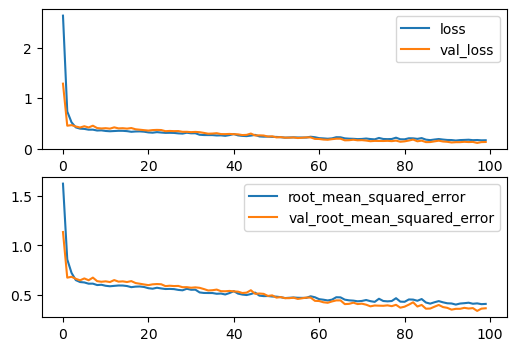

In [16]:
##Finally, let's try fitting and predicting with this bad boy:
history = model_wd.fit(X_train, y_train, epochs=100,
                       validation_split=0.1, verbose=False)


#See how we did:
#Make DataFrame
df = pd.DataFrame(history.history)

## Plot
fig, ax1 = plt.subplots(2,1, figsize=(6,4))

df[['loss', 'val_loss']].plot(ax=ax1[0])
df[['root_mean_squared_error', 'val_root_mean_squared_error']].plot(ax=ax1[1])


In [17]:
#mse_test = model.evaluate(X_test, y_test)
y_pred2 = model_wd.predict(X_test)


13/13 [==============================] - 0s 833us/step


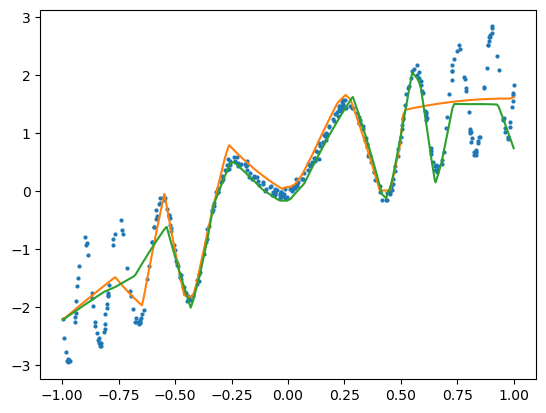

In [18]:
#Plot our data:
plt.plot(X_test.x, y_test, 'o', markersize=2);
plt.plot(X_test.x, y_pred1) #, 'o', markersize=2);
plt.plot(X_test.x, y_pred2) #, 'o', markersize=2);

In [19]:
#Check Weights:
output_layer.get_weights()

[array([[-0.37199885],
        [-0.3727118 ],
        [-0.12609652],
        [ 0.7043159 ],
        [ 0.384124  ],
        [ 1.3203369 ],
        [ 0.38271174],
        [ 0.5157549 ],
        [-0.2527627 ],
        [ 0.3515608 ],
        [-0.50234634],
        [-0.6788218 ],
        [-1.5805025 ]], dtype=float32),
 array([-0.0827998], dtype=float32)]

### Different Inputs for Each Path?

- We can use the functional API to send different (possibly overlapping) groups of inputs through deep and wide paths

<img src="wide_and_deep2.png" alt="Wide and Deep Architecture" style="width:325px;"/>

<br>

Let's send `x` and `sin_x` through the wide path; `x` and `x2` through the deep path

In [20]:
#Create our two input layers:
######
input_wide = tf.keras.layers.Input(shape=[2,])  # features 0 and 2

input_deep = tf.keras.layers.Input(shape=[2,])  # features 0 and 1

#We'll need normalization layers for both paths:
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()


#And the normalized inputs from each normalization layer:
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)


#Set up the deep path again:
#######
hidden_layer1 = tf.keras.layers.Dense(10, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(10, activation="relu")

hidden1 = hidden_layer1(norm_deep)
hidden2 = hidden_layer2(hidden1)


#Concatenation Layer for the two paths:
#######
concat = tf.keras.layers.concatenate([norm_wide, hidden2])


#Our final output:
output_layer = tf.keras.layers.Dense(1)

output = output_layer(concat)

#Create the model: We pass input_wide and input_deep as inputs:
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 normalization_3 (Normaliza  (None, 2)                    5         ['input_3[0][0]']             
 tion)                                                                                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 dense_6 (Dense)             (None, 10)                   30        ['normalization_3[0][0]'

In [22]:
## Look at some of our tensors:

In [23]:
input_wide

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'input_2')>

In [24]:
hidden1

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_6')>

In [25]:
## Once again, compile:
####

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])


In [26]:
#Create our wide and deep versions of the X_train, X_valid, and X_test:
X_train_wide, X_train_deep = X_train.iloc[:,[0,2]], X_train.iloc[:,[0,1]]

X_valid_wide, X_valid_deep = X_valid.iloc[:,[0,2]], X_valid.iloc[:,[0,1]]

X_test_wide, X_test_deep = X_test.iloc[:,[0,2]], X_test.iloc[:,[0,1]]


In [27]:
## And adapt the normalization layers:
#####

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)


In [28]:
#Check the mean and variance from one adapt:
display(norm_layer_deep.mean)

display(norm_layer_deep.variance)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.0556985, 0.3158628]], dtype=float32)>

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.31276053, 0.08218403]], dtype=float32)>

<Axes: >

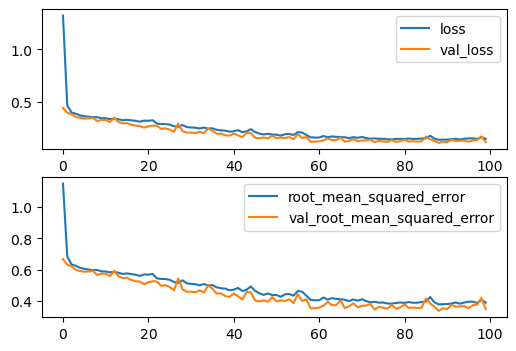

In [29]:
##Fit once again:
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=100,
                       validation_data=((X_valid_wide, X_valid_deep), y_valid), verbose=False)

#See how we did:
#Make DataFrame
df = pd.DataFrame(history.history)

## Plot
fig, ax1 = plt.subplots(2,1, figsize=(6,4))

df[['loss', 'val_loss']].plot(ax=ax1[0])
df[['root_mean_squared_error', 'val_root_mean_squared_error']].plot(ax=ax1[1])


13/13 [==============================] - 0s 667us/step


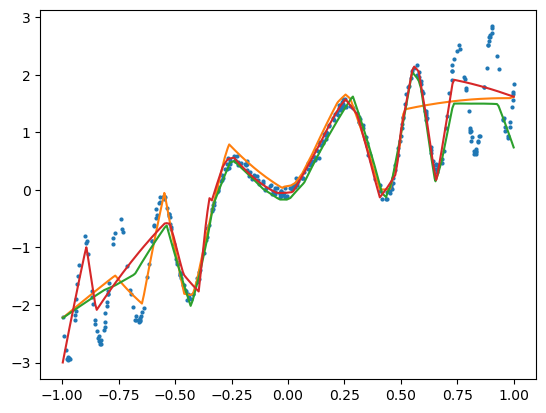

In [30]:
##Predictions?

y_pred3 = model.predict((X_test_wide, X_test_deep))

#Plot our data:
plt.plot(X_test.x, y_test, 'o', markersize=2);
plt.plot(X_test.x, y_pred1) #, 'o', markersize=2);
plt.plot(X_test.x, y_pred2) #, 'o', markersize=2);
plt.plot(X_test.x, y_pred3) #, 'o', markersize=2);

### Add Multiple Outputs

- Can use a single network to predict multiple outputs from the same data
- Can combine regression with classification task; e.g. locate and object (regression for coordinates) + classification for object type
- Can also use an auxiliary output for regularization or to force training on a subset of model
- Can also give different outputs different weights in determing overall loss

<img src="wide_and_deep3.png" alt="Wide and Deep Architecture" style="width:300px;"/>

In [31]:
##Let's build our architecture again:
########

#We'll reset here so our layers have consistent names:
####
tf.keras.backend.clear_session()


#Again, input layers:
input_wide = tf.keras.layers.Input(shape=[2])
input_deep = tf.keras.layers.Input(shape=[2])

#Normalization:
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()

#Get outputs of normalization
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)


#Feed norm_deep to deep path:
#We'll just combine creating the layer and passing the tensor through:
hidden1 = tf.keras.layers.Dense(10, activation="relu")(norm_deep)

hidden2 = tf.keras.layers.Dense(10, activation="relu")(hidden1)


#Concatenate again:
concat = tf.keras.layers.concatenate([norm_wide, hidden2])

#Main Output:
output = tf.keras.layers.Dense(1)(concat)

#Auxiliary Output:
aux_output = tf.keras.layers.Dense(1)(hidden2)


#Make the model:
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 normalization_1 (Normaliza  (None, 2)                    5         ['input_2[0][0]']             
 tion)                                                                                            
                                                                                                  
 input_1 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 10)                   30        ['normalization_1[0][0]'] 

In [33]:
## Compile, adapt, train:
########

#Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

#Adapt
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)


#Fit
## We can just use y_train as the auxiliary output for training:
history = model.fit((X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
                       validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)), verbose=False)

In [34]:
## Now look at our history
df = pd.DataFrame(history.history)
df

,loss,dense_2_loss,dense_3_loss,dense_2_root_mean_squared_error,dense_3_root_mean_squared_error,val_loss,val_dense_2_loss,val_dense_3_loss,val_dense_2_root_mean_squared_error,val_dense_3_root_mean_squared_error
0,1.404625,0.428031,0.976594,0.654240,0.988228,0.907055,0.431244,0.475811,0.656692,0.689790
1,0.810899,0.396760,0.414139,0.629889,0.643536,0.763321,0.377915,0.385406,0.614748,0.620811
2,0.785427,0.392422,0.393004,0.626436,0.626901,0.750066,0.378957,0.371109,0.615595,0.609187
3,0.761447,0.382292,0.379155,0.618298,0.615755,0.739977,0.375166,0.364811,0.612508,0.603996
4,0.759811,0.381523,0.378288,0.617675,0.615051,0.712133,0.362926,0.349207,0.602434,0.590937
...,...,...,...,...,...,...,...,...,...,...
95,0.473461,0.236104,0.237357,0.485906,0.487193,0.357507,0.179720,0.177786,0.423934,0.421647
96,0.478336,0.237605,0.240731,0.487447,0.490644,0.354365,0.176847,0.177517,0.420532,0.421328
97,0.470630,0.234234,0.236396,0.483977,0.486206,0.348743,0.173463,0.175280,0.416488,0.418665
98,0.457510,0.227428,0.230082,0.476895,0.479668,0.385389,0.192689,0.192699,0.438964,0.438975


<Axes: >

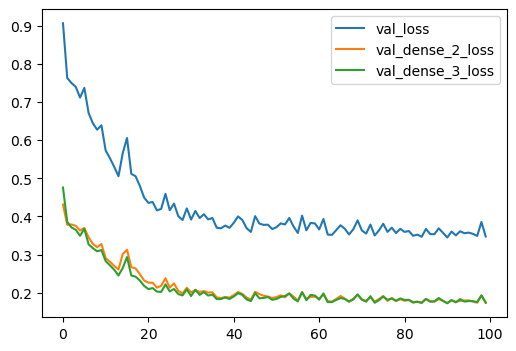

In [35]:
## Plot all three validation losses:
fig, ax1 = plt.subplots(1,1, figsize=(6,4))

df[['val_loss', 'val_dense_2_loss', 'val_dense_3_loss']].plot(ax=ax1)

In [36]:
## Note, we also have two outputs for our predictions now:
## We get a list of numpy arrays:
y_pred4 = model.predict((X_test_wide, X_test_deep))


13/13 [==============================] - 0s 917us/step


In [37]:
type(y_pred4)

list

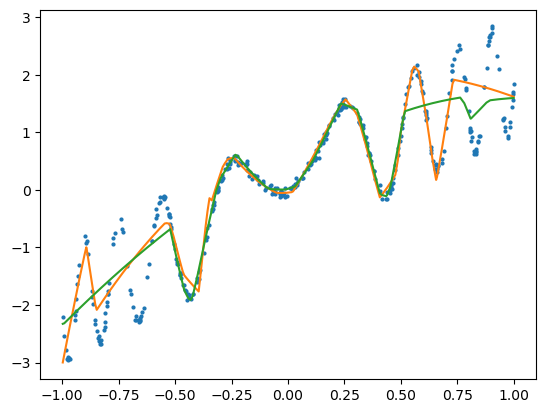

In [38]:
#Predictions? Yet Again



#Plot our data:
plt.plot(X_test.x, y_test, 'o', markersize=2);
plt.plot(X_test.x, y_pred3) #, 'o', markersize=2);
plt.plot(X_test.x, y_pred4[0]) #, 'o', markersize=2);


In [39]:
## Let's Also Evaluate:
###

eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))

#Unpack our tuple
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results


13/13 [==============================] - 0s 1ms/step - loss: 0.4215 - dense_2_loss: 0.2096 - dense_3_loss: 0.2119 - dense_2_root_mean_squared_error: 0.4578 - dense_3_root_mean_squared_error: 0.4603


## Subclassing API

- Sequential and Functional APIs: Declare layers and how they are connected.
- Model = Static graph of layers
- Can use subclassing API to add more dynamic layers

Let's clone a simple sequential model. For reference, our base model will be:

In [40]:
#Reference model, adapted from above:

#Normalization layer
normalization_layer = tf.keras.layers.Normalization(input_shape=X.shape[1:])

model_base = tf.keras.Sequential([
    normalization_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

#Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
#Compile
model_base.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
#Normalization
normalization_layer.adapt(X_train)

In [41]:
#Inherit from tf.keras.Model:

class SeqModel(tf.keras.Model):
    
    def __init__(self, units=[30,20,10], activation="relu", **kwargs):
        super().__init__(**kwargs)  # Needed to support naming the model
        
        #Create normalization layer:
        self.normalization_layer = tf.keras.layers.Normalization()
        
        self.hidden1 = tf.keras.layers.Dense(units[0], activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units[1], activation=activation)
        self.hidden3 = tf.keras.layers.Dense(units[2], activation=activation)
        
        self.my_output = tf.keras.layers.Dense(1)
        
        
    #Single input, single output
    def call(self, inputs):
        
        my_input = inputs
        norm = self.normalization_layer(my_input)
        
        hidden1 = self.hidden1(norm)
        hidden2 = self.hidden2(hidden1)
        hidden3 = self.hidden3(hidden2)
        
        output = self.my_output(hidden3)
        
        return output

In [42]:
#Make the Model:
model_seq = SeqModel([30,20,10], activation="relu", name="A_good_day_to_model")


#Compile as usual
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_seq.compile(loss="mse", optimizer=optimizer,
              metrics=["RootMeanSquaredError"])

#And adapt:
model_seq.normalization_layer.adapt(X_train)


In [43]:
## And now fit on data:
history = model_seq.fit(X_train, y_train, epochs=10)

Epoch 1/10
17/17 [==============================] - 1s 938us/step - loss: 1.5803 - root_mean_squared_error: 1.2571
Epoch 2/10
17/17 [==============================] - 0s 1ms/step - loss: 1.2699 - root_mean_squared_error: 1.1269
Epoch 3/10
17/17 [==============================] - 0s 1ms/step - loss: 0.9541 - root_mean_squared_error: 0.9768
Epoch 4/10
17/17 [==============================] - 0s 938us/step - loss: 0.6475 - root_mean_squared_error: 0.8047
Epoch 5/10
17/17 [==============================] - 0s 938us/step - loss: 0.4453 - root_mean_squared_error: 0.6673
Epoch 6/10
17/17 [==============================] - 0s 938us/step - loss: 0.3992 - root_mean_squared_error: 0.6319
Epoch 7/10
17/17 [==============================] - 0s 938us/step - loss: 0.3935 - root_mean_squared_error: 0.6273
Epoch 8/10
17/17 [==============================] - 0s 938us/step - loss: 0.3862 - root_mean_squared_error: 0.6215
Epoch 9/10
17/17 [==============================] - 0s 938us/step - loss: 0.3823 - r

In [44]:
model_seq.summary()

Model: "A_good_day_to_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normaliza  multiple                  7         
 tion)                                                           
                                                                 
 dense_8 (Dense)             multiple                  120       
                                                                 
 dense_9 (Dense)             multiple                  620       
                                                                 
 dense_10 (Dense)            multiple                  210       
                                                                 
 dense_11 (Dense)            multiple                  11        
                                                                 
Total params: 968 (3.79 KB)
Trainable params: 961 (3.75 KB)
Non-trainable params: 7 (32.00 Byte)
________________

#### Can add conditionals, loops, etc. in `call()` method.


### Layers using the Subclassing API

- We can also construct custom layers. The following creates a dense layer:

In [45]:
#Note tf.keras.layers.Layer:
#tf.keras.layers.Layer(
#    trainable=True, name=None, dtype=None, dynamic=False, **kwargs
#)


class MyDense(tf.keras.layers.Layer):
    
    def __init__(self, units=32, activation="relu", **kwargs):
        super().__init__(**kwargs)  # Takes care of trainable, name, etc.
        
        #Some number of units with an activation function
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        
    #Called the first time the layer is used
    #Need to figure out how many weights and biases are needed from shape of inputs to this layer
    #Will add weights and biases:
    def build(self, input_shape):
        
        #Weights:
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_normal',
                                 trainable=True)
        
        #Biases:
        self.b = self.add_weight(shape=(self.units,),
                               initializer='zeros',
                               trainable=True)
        
        
    #Now for the call: gives output from this layer as weights x inputs + biases:
    def call(self, inputs):
        return self.activation(tf.matmul(inputs, self.w) + self.b)
    
    
    #And get_config; return dictionary of configuration parameters for this layer
    def get_config(self):
        base_config = super().get_config()

        return {**base_config,
                'units': self.units,
                'activation': self.activation}
    
    

In [46]:
##Can use this layer with a Model:

#Create a model using Sequential API, but with custom layer

normalization_layer = tf.keras.layers.Normalization(input_shape=X.shape[1:])

model_base = tf.keras.Sequential([
    normalization_layer,
    MyDense(units=30, activation="relu"),
    MyDense(units=20, activation="relu"),
    MyDense(units=10, activation="relu"),
    MyDense(units=1, activation=None)
])

#Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
#Compile
model_base.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
#Normalization
normalization_layer.adapt(X_train)

In [47]:
#Make sure it works:
model_base.fit(X_train, y_train, epochs=100, verbose=False)


13/13 [==============================] - 0s 750us/step


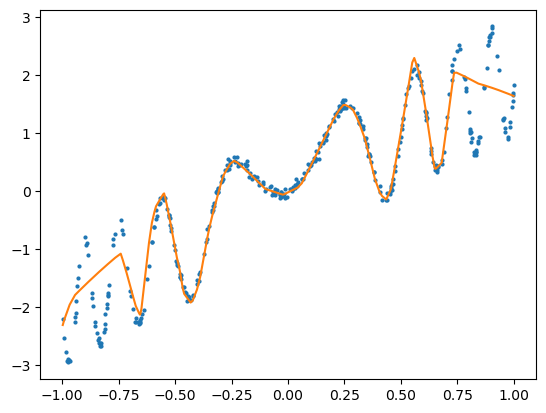

In [48]:
#Plot predictions
y_pred_again = model_base.predict(X_test)

#Plot predictions
plt.plot(X_test.x, y_test, 'o', markersize=2);
plt.plot(X_test.x, y_pred_again)


### A Custom Model with Custom Layers

Consider the following example, from Hands-On Machine Learning by Geron:

The residual blocks contain a skip connection, for *residual learning*

<img src="residual_model.png" alt="Residual Model" style="width:400px;"/>

<br>

Let's implement using the subclassing API.  First the `ResidualBlock` custom layer:

In [49]:
#Layer first:

class ResidualBlock(tf.keras.layers.Layer):
    
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        
        #Create a list of hidden layers, each with n_neurons:
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu', kernel_initializer='glorot_normal')
                       for i in range(n_layers)]
        
    #Call gives output from inputs:
    def call(self, inputs):
        
        Z = inputs
        
        #Iteratively apply layers:
        for layer in self.hidden:
            Z = layer(Z)
            
        #Skip connection means we add input to Z for total output:
        return inputs + Z
    

In [50]:
## And the model:
#######

class ResidualRegressor(tf.keras.Model):
    
    def __init__(self, n_neurons=10, **kwargs):
        
        super().__init__(**kwargs)
        
        #Create normalization layer:
        self.normalization_layer = tf.keras.layers.Normalization()
        
        #And the meat:
        self.hidden1 = tf.keras.layers.Dense(n_neurons, activation='relu',
                                             kernel_initializer='glorot_normal')
        
        #Residual Blocks:
        self.block1 = ResidualBlock(2,n_neurons)
        self.block2 = ResidualBlock(2,n_neurons)
        
        #Second dense hidden
        self.hidden2 = tf.keras.layers.Dense(n_neurons, activation='relu',
                                             kernel_initializer='glorot_normal')
        
        #Final output
        self.my_output = tf.keras.layers.Dense(1)
        
        
        
    def call(self, inputs):
        Z = self.hidden1(inputs)
        
        for i in range(1 + 3):
            Z = self.block1(Z)
            
        Z = self.block2(Z)
        
        Z = self.hidden2(Z)
        
        return self.my_output(Z)

In [51]:
### Make the model and run:
model_residual = ResidualRegressor(name='sweet_model')


#Compile as usual
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_residual.compile(loss="mse", optimizer=optimizer,
              metrics=["RootMeanSquaredError"])

#And adapt:
model_residual.normalization_layer.adapt(X_train)


## And now fit on data:
history = model_residual.fit(X_train, y_train, epochs=1000, verbose=False)

#model_residual.summary()


13/13 [==============================] - 0s 750us/step


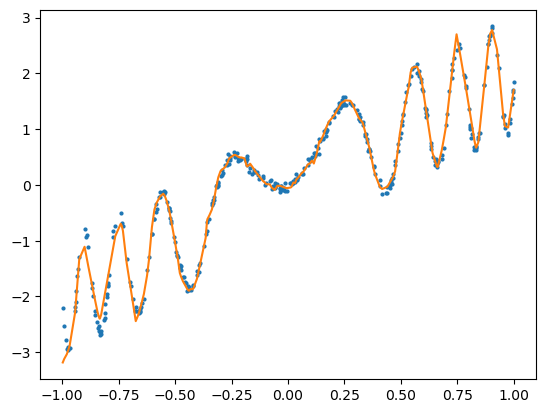

In [52]:
#Plot predictions
y_pred_again = model_residual.predict(X_test)

#Plot predictions
plt.plot(X_test.x, y_test, 'o', markersize=2);
plt.plot(X_test.x, y_pred_again)


### Saving Models

- It's easy to save and retrieve models
- Can save in either TensorFlow's *Saved-Model* format
- Or in HDF5 (Hierarchical Data Format)

In [53]:
##Let's save our model from above:
##Creates a folder:
model.save("my_keras_model", save_format="tf")

INFO:tensorflow:Assets written to: my_keras_model\assets


INFO:tensorflow:Assets written to: my_keras_model\assets


In [54]:
##Can load back in:

model_load = tf.keras.models.load_model("my_keras_model")

model_load.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 normalization_1 (Normaliza  (None, 2)                    5         ['input_2[0][0]']             
 tion)                                                                                            
                                                                                                  
 input_1 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 10)                   30        ['normalization_1[0][0]'] 

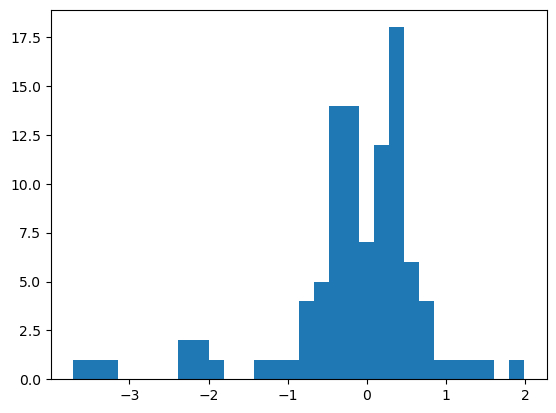

In [55]:
#Can crudely check that we have the trained weights:
plt.hist(model_load.get_layer('dense_1').get_weights()[0].flatten(), bins=30);

## Callbacks

- `fit()` methods takes `callbacks` argument = list of object to call before/after training, before/after each epoch

- Useful for saving checkpoints of model during long training

- Can also use to save only best run based on validation set

In [90]:
## ModelCheckpoint:

#fp = 'checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
fp = 'checkpoints/weights.{epoch:02d}.hdf5'

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(fp,
                                                   save_weights_only=True,
                                                   save_freq="epoch",
                                                   save_best_only=False)

In [91]:
history = model.fit((X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
                    callbacks=[checkpoint_cb])

Epoch 1/10
17/17 [==============================] - 0s 6ms/step - loss: 0.1765 - dense_2_loss: 0.0885 - dense_3_loss: 0.0879 - dense_2_root_mean_squared_error: 0.2975 - dense_3_root_mean_squared_error: 0.2965 - val_loss: 0.2165 - val_dense_2_loss: 0.1083 - val_dense_3_loss: 0.1082 - val_dense_2_root_mean_squared_error: 0.3291 - val_dense_3_root_mean_squared_error: 0.3290
Epoch 2/10
17/17 [==============================] - 0s 3ms/step - loss: 0.1757 - dense_2_loss: 0.0888 - dense_3_loss: 0.0869 - dense_2_root_mean_squared_error: 0.2981 - dense_3_root_mean_squared_error: 0.2948 - val_loss: 0.2170 - val_dense_2_loss: 0.1085 - val_dense_3_loss: 0.1085 - val_dense_2_root_mean_squared_error: 0.3294 - val_dense_3_root_mean_squared_error: 0.3294
Epoch 3/10
17/17 [==============================] - 0s 3ms/step - loss: 0.1700 - dense_2_loss: 0.0857 - dense_3_loss: 0.0844 - dense_2_root_mean_squared_error: 0.2927 - dense_3_root_mean_squared_error: 0.2904 - val_loss: 0.2002 - val_dense_2_loss: 0.10

In [92]:
#Load the weights back in:
######

#fp = f'checkpoints/weights.{10:02d}-{0.21:.2f}.hdf5'
fp = f'checkpoints/weights.{10:02d}.hdf5'

model.load_weights(fp)

In [93]:
## Early Stopping Callback?
############

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [96]:
history = model.fit((X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
                    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
                    callbacks=[checkpoint_cb, early_stopping_cb], verbose=False)

In [98]:
pd.DataFrame(history.history)

,loss,dense_2_loss,dense_3_loss,dense_2_root_mean_squared_error,dense_3_root_mean_squared_error,val_loss,val_dense_2_loss,val_dense_3_loss,val_dense_2_root_mean_squared_error,val_dense_3_root_mean_squared_error
0,0.178344,0.089321,0.089023,0.298867,0.298367,0.250940,0.127312,0.123628,0.356809,0.351607
1,0.179449,0.089999,0.089450,0.299998,0.299083,0.214209,0.105913,0.108296,0.325443,0.329083
2,0.169979,0.085063,0.084915,0.291656,0.291402,0.237165,0.119068,0.118097,0.345063,0.343652
3,0.176982,0.089138,0.087844,0.298560,0.296385,0.200660,0.100569,0.100091,0.317126,0.316372
4,0.191966,0.096132,0.095834,0.310052,0.309571,0.209624,0.107212,0.102411,0.327433,0.320018
5,0.173307,0.087168,0.086139,0.295242,0.293495,0.204863,0.101606,0.103257,0.318757,0.321337
6,0.167607,0.083478,0.084129,0.288926,0.290049,0.199886,0.100384,0.099502,0.316835,0.315439
7,0.168194,0.084537,0.083657,0.290752,0.289236,0.204326,0.100213,0.104114,0.316564,0.322666
8,0.176128,0.088441,0.087687,0.297389,0.296120,0.196033,0.098742,0.097291,0.314232,0.311915
9,0.173421,0.086974,0.086447,0.294913,0.294019,0.205081,0.103177,0.101904,0.321211,0.319224


## TensorBoard

In [56]:
from pathlib import Path
from time import strftime

#Get a path for a log directory
def get_logdir(root_logdir='my_logs'):
    return Path(root_logdir) / strftime('run_%Y_%m_%d_%H_%M_%S')

#Get
logdir = get_logdir()
logdir

WindowsPath('my_logs/run_2023_10_25_14_53_33')

In [99]:
#From: https://www.tensorflow.org/tensorboard/get_started

mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

def create_model():
    return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28), name='layers_flatten'),
    tf.keras.layers.Dense(512, activation='relu', name='layers_dense'),
    tf.keras.layers.Dropout(0.2, name='layers_dropout'),
    tf.keras.layers.Dense(10, activation='softmax', name='layers_dense_2')
  ])


In [100]:
model = create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

log_dir = get_logdir()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])


Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2201 - accuracy: 0.9348 - val_loss: 0.1279 - val_accuracy: 0.9624
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0985 - accuracy: 0.9697 - val_loss: 0.0750 - val_accuracy: 0.9762
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0683 - accuracy: 0.9787 - val_loss: 0.0701 - val_accuracy: 0.9790
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0544 - accuracy: 0.9826 - val_loss: 0.0659 - val_accuracy: 0.9811
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0432 - accuracy: 0.9862 - val_loss: 0.0637 - val_accuracy: 0.9807


In [106]:
%reload_ext tensorboard
%tensorboard --logdir 'my_logs/run_2023_10_25_15_28_16' --host localhost

## Tuning HyperParameters, Number of Layers, etc.

- Next time!